# Machine learning for trading (Gold)


## Data loading


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler


import warnings
warnings.filterwarnings('ignore')


In [38]:
## Load yfinance Gold data
yf = False

if yf:
  import yfinance as yf
  # Define the ticker symbol
  tickerSymbol = 'GC=F'
  # Get the data for this ticker
  tickerData = yf.Ticker(tickerSymbol)
  # Get the historical prices for this ticker
  data = tickerData.history(period='1d', start='2012-7-12')
else:
  data = pd.read_csv('gc_data_2012_2023_tradingview.csv', parse_dates=['Date'], index_col='Date')


In [39]:
data

,open,high,low,close
Date,,,,
2011-04-17 22:00:00+00:00,1488.0,1498.6,1477.8,1492.9
2011-04-18 22:00:00+00:00,1496.6,1500.5,1488.2,1495.1
2011-04-19 22:00:00+00:00,1496.1,1506.5,1493.8,1498.9
2011-04-20 22:00:00+00:00,1502.0,1509.6,1500.4,1503.8
2011-04-24 22:00:00+00:00,1510.7,1519.2,1502.2,1509.1
...,...,...,...,...
2023-07-30 22:00:00+00:00,1997.9,2010.9,1986.7,2009.2
2023-07-31 22:00:00+00:00,2004.2,2004.4,1978.3,1982.3
2023-08-01 22:00:00+00:00,1988.9,1992.2,1969.1,1975.0


## Check GPU


In [40]:
if yf:
  data = data.drop(['Dividends','Volume', 'Stock Splits'],axis = 1)
  data.columns = ['Open', 'High', 'Low', 'Close']
else:
  data.columns = ['Open', 'High', 'Low', 'Close']
  data['Close'] = data['Close'].astype(float)
  data['Open'] = data['Open'].astype(float)
  data['High'] = data['High'].astype(float)
  data['Low'] = data['Low'].astype(float)

data = data.dropna()
data = data.sort_values(by="Date", ascending=True)
data.to_csv('gcdata.csv')
#data.columns = ['Date','Open', 'High', 'Low', 'Close']


## Plotting the market data


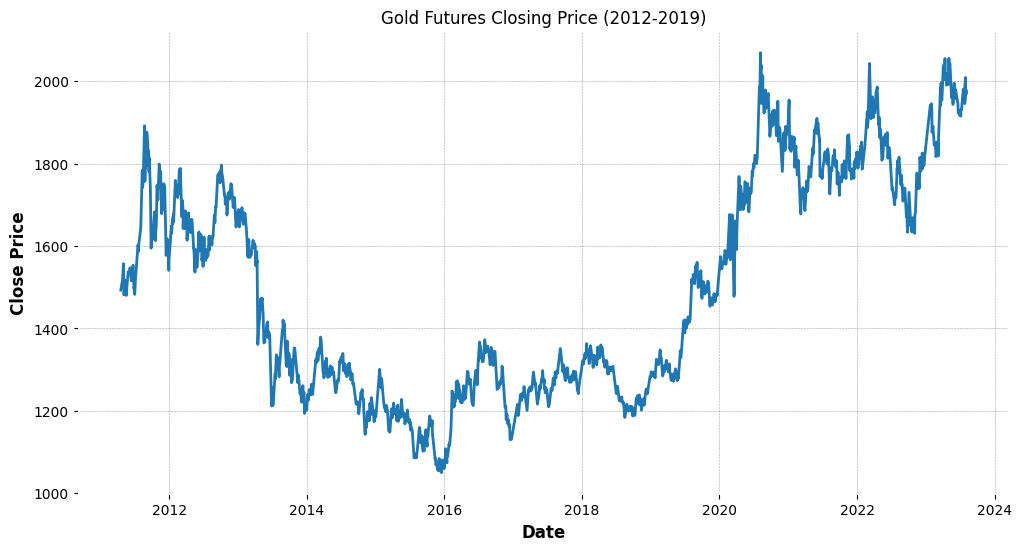

In [41]:
# Plotting
plt.figure(figsize=(12,6))
plt.plot(data['Close'])
plt.title('Gold Futures Closing Price (2012-2019)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

In [42]:
data_raw = data.copy()

In [43]:
data_raw.head()

,Open,High,Low,Close
Date,,,,
2011-04-17 22:00:00+00:00,1488.0,1498.6,1477.8,1492.9
2011-04-18 22:00:00+00:00,1496.6,1500.5,1488.2,1495.1
2011-04-19 22:00:00+00:00,1496.1,1506.5,1493.8,1498.9
2011-04-20 22:00:00+00:00,1502.0,1509.6,1500.4,1503.8
2011-04-24 22:00:00+00:00,1510.7,1519.2,1502.2,1509.1


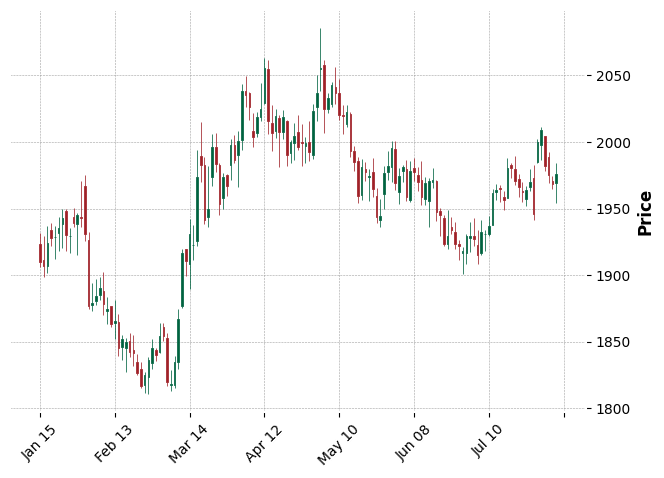

In [44]:
import mplfinance as mpf
mpf.plot(data.loc['01-13-2023':],type='candle', style='charles')

In [45]:
#data_raw.to_csv("gc_data_2012_2023Jul.csv")

## Defining the features


In [46]:
#defining the features
def featurize(data):
  
    #Analyse the distribution of open - low (if candle is bullish) and open - high (if candle is bearish)
    data['open_low'] = data['Open'] - data['Low']
    data['open_high'] = data['High'] - data['Open']
    data['open_close'] = data['Open'] - data['Close']
    data['high_low'] = data['High'] - data['Low']
    data['return'] = data['Close'] - data['Open']
    data['candleToday'] = [1 if x > 0 else 0 for x in data['return']]
    data['absreturn'] = abs(data['return'])

    return data

In [47]:
data = featurize(data)

In [48]:
#Plot distribution of stop loss values for cases of bull candles 
bull = data[data['candleToday'] == 1]
bear = data[data['candleToday'] == 0]

In [49]:
import plotly.express as px
fig_bull = px.histogram(bull, x='open_low', nbins=100,title="Stop Loss Distribution for Bullish Trades")
fig_bull.show()

#what is the quantile of above 8.5?
qt = 0.85
qtr = 0.65
print(f'quantile {qt*100}% open_minus_low is {bull["open_low"].quantile(qt)}')
print(f'quantile {qtr*100}% return is {bear["absreturn"].quantile(qtr)}')

quantile 85.0% open_minus_low is 10.400000000000091
quantile 65.0% return is 10.200000000000045


In [50]:
fig_bull = px.histogram(bear, x='absreturn', nbins=100,title="Stop Loss Distribution for Bullish Trades")
fig_bull.show()

In [59]:
import plotly.express as px
fig_bear = px.histogram(bear, x='open_high', nbins=100,title="Stop Loss Distribution for Bearish Trades")
fig_bear.show()

#what is the quantile of above 8.5?
qt = 0.85
qtr = 0.65
print(f'quantile {qt*100}% open_minus_high is {bear["open_high"].quantile(qt)}')
print(f'quantile {qtr*100}% return is {bull["absreturn"].quantile(qtr)}')

quantile 85.0% open_minus_high is 9.200000000000045
quantile 65.0% return is 10.0


In [63]:
fig_bear = px.histogram(bull, x='absreturn', nbins=100,title="Stop Loss Distribution for Bullish Trades")
fig_bear.show()

### other features


## Train and test set


In [60]:
drop_feature_list = ['Open','High','Low','Close','maFast','maSlow', 'ma2Slow','candleNextDay','returnNextDay','returnToday',
                       'candlelag_3', 'candlelag_4','candlelag_5', 'candlelag_6', 'CloseTomaFast_3',  'CloseTomaFast_4',
                       'CloseTomaFast_5',  'CloseTomaFast_6','CloseTomaSlow_3','CloseTomaSlow_4', 'CloseTomaSlow_5', 'CloseTomaSlow_6',
                       'candlelag_2', 'CloseTomaFast_2', 'CloseTomaSlow_2','maFastTomaSlow_2', 'maFastTomaSlow_3', 'maFastTomaSlow_4',
                       'maFastTomaSlow_5', 'maFastTomaSlow_6',
                       'Close_1','candleTarget', 'Open_1'
                        #'MaFastMinusMa2Slow'
                       ]

#normalise features
feature_list = ['MaFastMinusMaSlow', 'MaFastMinusMa2Slow', 'MaSlowMinusMa2Slow',
                  'closeMinusMaFast', 'closeMinusMaSlow', 'close1MinusMaFast',
                  'close1MinusMaSlow', 'closeMinusHigh_7', 'closeMinusLow_7',
                  'highMinusHigh_7', 'lowMinusLow_7']

def train_validate(data = data, tsplit=1000, estimators=1000, fast=7, slow=21, twoslow=35):

  #Generate features
  data = featurize(data, fast, slow, twoslow)
  data = data.dropna()

  #Define the training set
  X = data.drop(drop_feature_list, axis = 1)
  Y = data.candleNextDay
  returns = data.returnNextDay
  X.tail(5)

  #train_test split - temporal split
  tsplit = tsplit
  XTrain = X[:tsplit]
  YTrain = Y[:tsplit]
  returnsTrain = returns[:tsplit]
  XTest = X[tsplit+1:]
  YTest = Y[tsplit+1:]
  returnsTest = returns[tsplit+1:]

  #Normalize
  for feature in feature_list:
    if feature in XTrain.columns:
      minmaxsc_1 = MinMaxScaler()
      XTrain[feature] = minmaxsc_1.fit_transform(XTrain[feature].values.reshape(-1,1))
      XTest[feature] = minmaxsc_1.transform(XTest[feature].values.reshape(-1,1))
    else:
      pass

  #Function to Calculate the true return
  def predictedReturn(pred, YTest, returnsTest):
      results = pd.Series([res if var == i else -res for res,var,i in list(zip(returnsTest, pred, YTest))])
      cumResults = results.cumsum()
      return results, cumResults

  #begin training and testing
  from sklearn.ensemble import RandomForestRegressor
  rf = RandomForestRegressor(n_estimators=estimators,
                                  random_state=1,
                                  n_jobs=-1)

  rf.fit(XTrain, YTrain)

  ## Making the predictions
  predRF = pd.Series(rf.predict(XTest))
  predRF = pd.Series([1 if var > 0.5 else 0 for var in predRF])
  predRF.index = YTest.index
  equityRF,cumEquityRF = predictedReturn(predRF, YTest, returnsTest)



  clScaled = -500 + (data.Close[tsplit+1:] - data.Close[tsplit+1:].min()) / (data.Close[tsplit+1:].max() - data.Close[tsplit+1:].min()) * 1000

  # Calculate the confusion matrix and accuracy
  from sklearn.metrics import confusion_matrix, accuracy_score
  conf_matrix = confusion_matrix(YTest, predRF)
  accuracy = accuracy_score(YTest, predRF)
  #print(f'The accuracy is {round(accuracy*100,2)}%')

  ## Plot the cum equity curve
  if cumEquityRF.iloc[-1] > 1250:
    plt.figure()
    cumEquityRF.plot(figsize=(15, 7),  color = 'g')
    plt.plot(range(1,len(data.Close)-tsplit), clScaled, color = 'r', linestyle = 'dashed')
    plt.xlabel('number of trades')
    plt.ylabel('cum return (x10 USD)')
    plt.title(f'return for strategy {tsplit}-{estimators}-{fast}-{slow}-{twoslow} - acc: {round(accuracy, 2)}')


  cumEquityRF.index = XTest.index
  return rf, XTrain, cumEquityRF, equityRF


In [61]:
test_all = False

if test_all:
  for ema in [28, 35, 42, 49, 56, 63]:
    for split in [300, 400, 500,600,700,800, 900, 1000, 1100, 1200]:
      for estimator in [1,2,3,5, 7, 15, 35, 65, 85, 115, 150, 195]:
        rf,XTrain,_,_= train_validate(data_raw, split,estimator, 7, 21, ema)

In [62]:
spl1, est1, emaf1, emas1, emass1 = 500,195, 7, 21, 28  #1
spl4, est4, emaf4, emas4, emass4 = 900,115, 7, 21, 35  #Good
spl5, est5, emaf5, emas5, emass5 = 900,7, 7, 21, 42  #Good
spl6, est6, emaf6, emas6, emass6 = 600,85, 7, 21, 49   #Good
spl7, est7, emaf7, emas7, emass7 = 1100,7, 7, 21, 49  #Good
spl8, est8, emaf8, emas8, emass8 = 600,85, 7, 21, 56  #Good
spl9, est9, emaf9, emas9, emass9 = 1100,35, 7, 21, 56 #Good
spl10, est10, emaf10, emas10, emass10 = 900,85, 7, 21, 63 #Good
spl11, est11, emaf11, emas11, emass11 = 900,85, 7, 21, 63 #Good
spl12, est12, emaf12, emas12, emass12 = 600,85, 7, 21, 56 #Good



rf1,XTrain,cum1, pred1 = train_validate(data_raw, spl1, est1, emaf1, emas1, emass1)
rf4,XTrain,cum4, pred4 = train_validate(data_raw, spl4, est4, emaf4, emas4, emass4)

rf5,XTrain,cum5, pred5 = train_validate(data_raw, spl5, est5, emaf5, emas5, emass5)
rf6,XTrain,cum6, pred6 = train_validate(data_raw, spl6, est6, emaf6, emas6, emass6)

rf7,XTrain,cum7, pred7 = train_validate(data_raw, spl7, est7, emaf7, emas7, emass7)
rf8,XTrain,cum8, pred8 = train_validate(data_raw, spl8, est8, emaf8, emas8, emass8)

rf9,XTrain,cum9, pred9 = train_validate(data_raw, spl9, est9, emaf9, emas9, emass9)
rf10,XTrain,cum10, pred10 = train_validate(data_raw, spl10, est10, emaf10, emas10, emass10)
rf11,XTrain,cum11, pred11 = train_validate(data_raw, spl11, est11, emaf11, emas11, emass11)
rf12,XTrain,cum12, pred12 = train_validate(data_raw, spl12, est12, emaf12, emas12, emass12)

cum_total = cum1 + cum4 + cum5 + cum6 + cum7 + cum8 + cum9 + cum10 +cum11 + cum12

TypeError: featurize() takes 1 positional argument but 4 were given

<Axes: xlabel='Date'>

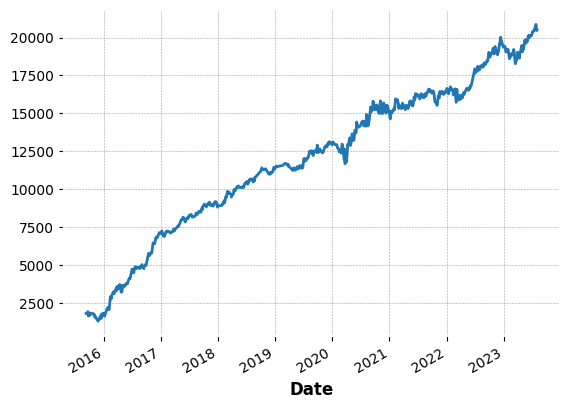

In [ ]:
cum_total.plot()

In [ ]:
def live_predict(rf, tsplit, fast, slow, twoslow):

  #Generate features
  data = featurize(data_raw, fast, slow, twoslow)

  #Define the training set
  X = data.drop(drop_feature_list, axis = 1)
  X = X.dropna()

  #train_test split - temporal split
  tsplit = tsplit
  XTrain = X[:tsplit]
  XTest = X[tsplit+1:]

  #Normalize features
  for feature in feature_list:
    if feature in XTrain.columns:
      minmaxsc_1 = MinMaxScaler()
      XTrain[feature] = minmaxsc_1.fit_transform(XTrain[feature].values.reshape(-1,1))
      XTest[feature] = minmaxsc_1.transform(XTest[feature].values.reshape(-1,1))
    else:
      pass

  ## Making the predictions
  predRF = pd.Series(rf.predict(XTest))
  predRF = pd.Series([1 if var > 0.5 else 0 for var in predRF])
  predRF.index = XTest.index

  return predRF

In [ ]:
dir1 = live_predict(rf1, spl1,emaf1, emas1, emass1).iloc[-1:]
dir4 = live_predict(rf4, spl4,emaf4, emas4, emass4).iloc[-1:]
dir5 = live_predict(rf5, spl5,emaf5, emas5, emass5).iloc[-1:]
dir6 = live_predict(rf6, spl6,emaf6, emas6, emass6).iloc[-1:]
dir7 = live_predict(rf7, spl7,emaf7, emas7, emass7).iloc[-1:]
dir8 = live_predict(rf8, spl8,emaf8, emas8, emass8).iloc[-1:]
dir9 = live_predict(rf9, spl9,emaf9, emas9, emass9).iloc[-1:]
dir10 = live_predict(rf10, spl10,emaf10, emas10, emass10).iloc[-1:]
dir11 = live_predict(rf11, spl11,emaf11, emas11, emass11).iloc[-1:]
dir12 = live_predict(rf12, spl12,emaf12, emas12, emass12).iloc[-1:]


In [ ]:
# Sum of buy and sell signals
buy = []
sell = []
for trade in [dir1,dir4, dir5, dir6, dir7, dir8, dir9, dir10, dir11, dir12]:
  if trade.values == 1:
    buy.append(1)
  else:
    sell.append(1)

print(f'The number of buy orders are {np.sum(buy)}') 
print(f'The number of sell orders are {np.sum(sell)}') 
np.sum(buy) - np.sum(sell)


The number of buy orders are 3
The number of sell orders are 7


-4

In [ ]:
print(f'{dir1} {dir4} {dir5} {dir6} {dir7} {dir8} {dir9} {dir10} {dir11} {dir12}')

Date
2023-08-03 22:00:00+00:00    0
dtype: int64 Date
2023-08-03 22:00:00+00:00    1
dtype: int64 Date
2023-08-03 22:00:00+00:00    0
dtype: int64 Date
2023-08-03 22:00:00+00:00    1
dtype: int64 Date
2023-08-03 22:00:00+00:00    1
dtype: int64 Date
2023-08-03 22:00:00+00:00    0
dtype: int64 Date
2023-08-03 22:00:00+00:00    0
dtype: int64 Date
2023-08-03 22:00:00+00:00    0
dtype: int64 Date
2023-08-03 22:00:00+00:00    0
dtype: int64 Date
2023-08-03 22:00:00+00:00    0
dtype: int64


In [ ]:
## Plot the histogram of the predictions
import plotly.express as px
#add line in between the histogram bars
px.histogram(pred1, pred8.values, nbins=100, title='Histogram of predictions', 
             opacity=0.8, color_discrete_sequence=['indianred'], template='plotly_white').update_traces(marker_line_width=0.5, marker_line_color="black")
              




In [ ]:
# mean of negative returns and mean of positive returns
def mean_neg_pos_returns(pred):
    results = pred
    neg_returns = results[results < 0]
    pos_returns = results[results > 0]
    return neg_returns.mean(), pos_returns.mean()

In [ ]:
for i in [pred1, pred11, pred12, pred4,
          pred5, pred6, pred7, pred8, pred10]:
  print(mean_neg_pos_returns(i))


(-9.311658456486045, 9.79435069699193)
(-9.268644906033634, 9.815187713310578)
(-8.933788395904438, 9.795725190839695)
(-9.2615906886518, 9.830989583333329)
(-9.313188976377958, 9.77874892887746)
(-9.14520547945206, 9.605175038051748)
(-9.336734693877556, 10.013580246913579)
(-8.933788395904438, 9.795725190839695)
(-9.268644906033634, 9.815187713310578)


## Using Random Forest algo to make predictions on next day price direction



In [ ]:
# Get feature importances from the model
feature_importances = rf1.feature_importances_

# Create a dataframe for visualization
importances_df = pd.DataFrame({
    'Feature': XTrain.columns,
    'Importance': feature_importances
})

# Sort the dataframe by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

importances_df

,Feature,Importance
1,close1MinusMaFast,0.137661
0,closeMinusMaFast,0.112358
5,closeMinusLow_7,0.101795
6,highMinusHigh_7,0.092686
8,MaSlowMinusMa2Slow,0.090800
4,closeMinusHigh_7,0.081724
2,closeMinusMaSlow,0.075623
3,MaFastMinusMaSlow,0.070275
7,MaFastMinusMa2Slow,0.068446
12,sum_bull_lag,0.035223
